In [14]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import pandas as pd
import scipy.stats

# Outputs
OUTPATH = "pdfs"
PREFIX = "SuppFig"

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
MUTEADIR="/storage/mgymrek/ssc-denovos/mutea-results/"
codis = pd.read_csv("../CODIS.bed", sep="\t", names=["chrom","pos","end","marker","mutrate"])
codis = codis[codis["mutrate"] != "?"]
denovo = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary.bed.gz"), sep="\t")
denovo["chrom"] = denovo["#chrom"]
denovo["pos"] = denovo["start"]
codis = pd.merge(codis, denovo, on=["chrom","pos"])
codis["mutrate"] = codis["mutrate"].apply(float)
mutea = pd.read_csv(os.path.join(MUTEADIR, "ssc_autosomal_perlocus_observed.bed.gz"), sep="\t")
mutea["pos"] = mutea["start"]
codis = pd.merge(mutea, codis, on=["chrom","pos"])

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
# scaling
mutea_test = pd.read_csv(os.path.join(MUTEADIR, "ssc_hipstr_mutea_codis.tab"),
                   names=["chrom","pos","end","log10mu","beta","pgeom","log10mu_se","nsamples","center"], sep="\t")
codis_test = pd.merge(mutea_test, codis, on=["chrom","pos"])
codis_test["scale"] = (10**codis_test["log10mu"]/codis_test["mutrate"])
# Remove CSF1PO, outlier
np.mean(codis_test[codis_test["marker"]!="CSF1PO"]["scale"])

0.49825259769365626

# SuppFig A: Compare MUTEA and NIST rates

(0.72506336535032456, 0.0022240752650294184)
15


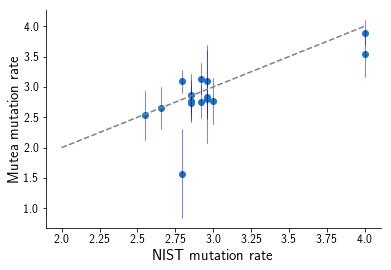

In [16]:
# Mutea CODIS estimates vs. NIST reported
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(codis["mutrate"].apply(lambda x: -1*np.log10(x)),
          codis["ml_mu"]*-1);
for i in range(codis.shape[0]):
    xval = codis["mutrate"].apply(lambda x: -1*np.log10(x)).values[i]
    mean = -1*codis["ml_mu"].values[i]
    se = codis["ml_mu_stderr"].values[i]
    ax.plot([xval,xval],[mean-1.96*se,mean+1.96*se], color="blue", linewidth=0.5)
ax.plot([2.0,4.0],[2.0,4.0], linestyle="dashed", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("NIST mutation rate", size=15)
ax.set_ylabel("Mutea mutation rate", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
print(scipy.stats.pearsonr(codis["mutrate"].apply(lambda x: -1*np.log10(x)), codis["ml_mu"]*-1))
print(codis.shape[0])
fig.savefig(os.path.join(OUTPATH, "%s_CODISMutea.pdf"%PREFIX))

# SuppFig B: Compare SSC observed denovos to estimated rates

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


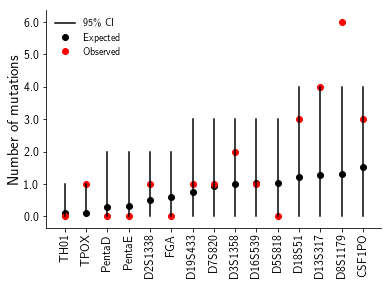

In [12]:
# Look at denovos vs. reported CODIS rate

nsim=100000
# Get expected num mutations for each marker
codis["codis_exp"] = codis.apply(lambda x: x["mutrate"]*x["total_children"], 1)
codis["codis_se"] = codis.apply(lambda x: np.sqrt(np.var(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim))), 1)
codis["codis_low"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 2.5), 1)
codis["codis_high"] = codis.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 97.5), 1)
codis["pval"] = codis.apply(lambda x: np.mean([item>=x["total_mutations"] for item in np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim)]), 1)

fig = plt.figure()
ax = fig.add_subplot(111)
codis = codis.sort("codis_exp")
codis["order"] = range(codis.shape[0])
ax.scatter(codis["order"], codis["codis_exp"], color="black", label="Expected")
for i in range(codis.shape[0]):
    x = codis["order"].values[i]
    low = codis["codis_low"].values[i]
    high = codis["codis_high"].values[i]
    obs = codis["total_mutations"].values[i]
    if i==0:
        ax.scatter([x],[obs], color="red", label="Observed")
        ax.plot([x,x],[low,high], color="black", label="95\% CI")
    else:
        ax.scatter([x],[obs], color="red")
        ax.plot([x,x],[low,high], color="black")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(codis["order"])
ax.set_xticklabels(codis["marker"], rotation=90, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Number of mutations", size=15)
ax.legend(loc="upper left", frameon=False)
fig.savefig(os.path.join(OUTPATH, "%s_CODISDenovo.pdf"%PREFIX))